# Manuscript Utils
This notebook contains useful functions for generating figures in the paper.

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sys
sys.path.append("../../python_src/")
from figures_utils import generate_experimental_df

## Expected Plotting
Stacked bar plots with tabulated relative abundances.

In [30]:
def get_all_expected(root_dir: str, rank="Genus") -> pd.DataFrame:
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            # print("files: ", files)
            if f"expected_{rank.lower()}_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=[rank, 'RA', "TAX_ID"], header=0)
                df["Source"] = root.split("/")[-1]

                # Files are of s#_expected.csv, so we can split on the underscore and take the first part.
                df["SampleID"] = f.split("_")[0]

                # Pipeline for easier grouping later.
                df['Pipeline'] = "Expected"

                combined_expected = pd.concat([combined_expected, df], axis=0)

    return combined_expected

def get_all_relabund_files(root_dir: str, rank="genus") -> pd.DataFrame:
    """
    Parameters:
        root_dir: str 
            The root directory to search for relabund files.
        rank: str
            The taxonomic rank to search for. Default is "genus".
    Returns:
        relabund_files: pd.DataFrame

    Traverses the BASE ROOT directory and searches for ALL {rank}_relabund_annotated files. These are concatenated. \\
    Then, it then returns a dataframe with the sample ID and the path to the relabund file.
    """
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f"{rank.lower()}_relabund_annotated" in f and f.endswith(".csv"):
                # print(root, f)
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, rank)
                exp["Pipeline"] = os.path.dirname(p).split('/')[-1]

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-2]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]
                # display(exp.head(10))

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    # Ensure that the RA column is a float.
    combined_df['RA'] = combined_df['RA'].astype(float)

    return combined_df

# expected = get_all_expected("../../pipelines/", rank="Genus")
# display(expected.head(50))
# # Print the number of occurences in Source
# expected["Source"].value_counts()

In [31]:
def plot_pies(expected: pd.DataFrame):
    for source, source_df in expected.groupby("Source"):
        for sample, sample_df in source_df.groupby("SampleID"):
            plot_df = sample_df.loc[sample_df["RA"] > 0]

            plot_df[["RA"]].T.plot(kind="barh", stacked=True, figsize=(20, 10))
            plt.show()

            plt.pie(plot_df["RA"], labels=plot_df.index, autopct='%1.1f%%')
            plt.show()

            # sns.barplot(x='SampleID', y='RA', hue="Genus", data=plot_df)
            # plt.show()

## Creation of comparative stacked bar plots or heatmaps.

We want to create a figure that summarizes the relative abundances of the expected with comparison to each pipeline.

In [43]:
def fill_wgsa(df: pd.DataFrame, src: str, sampleID: str, rank: str) -> pd.DataFrame:
    # We need to get the sum of the RA column for the dataframe.
    # If it it less than 1, we need to fill the difference with a row called "Unclassified".
    df.reset_index(inplace=True)

    # Get the sum of the RA column.
    sum_ra = df["RA"].sum()
    diff = 1 - sum_ra

    # Rename index to rank.
    df.index.names = [rank]

    # If the difference is greater than 0, we need to add a row.
    # new_row = pd.DataFrame({rank: "Unclassified", "RA": diff, "TAX_ID": "Unclassified", "Source": src, "SampleID": sampleID, "Pipeline": "wgsa2"}, index=[0])
    new_row = pd.DataFrame({rank: "Unclassified", "RA": diff}, index=[0])
    df = pd.concat([df, new_row], axis=0)

    print(df["RA"].sum())

    df.set_index(rank, inplace=True)

    return df

source:  bmock12
source:  camisimGI
1.0


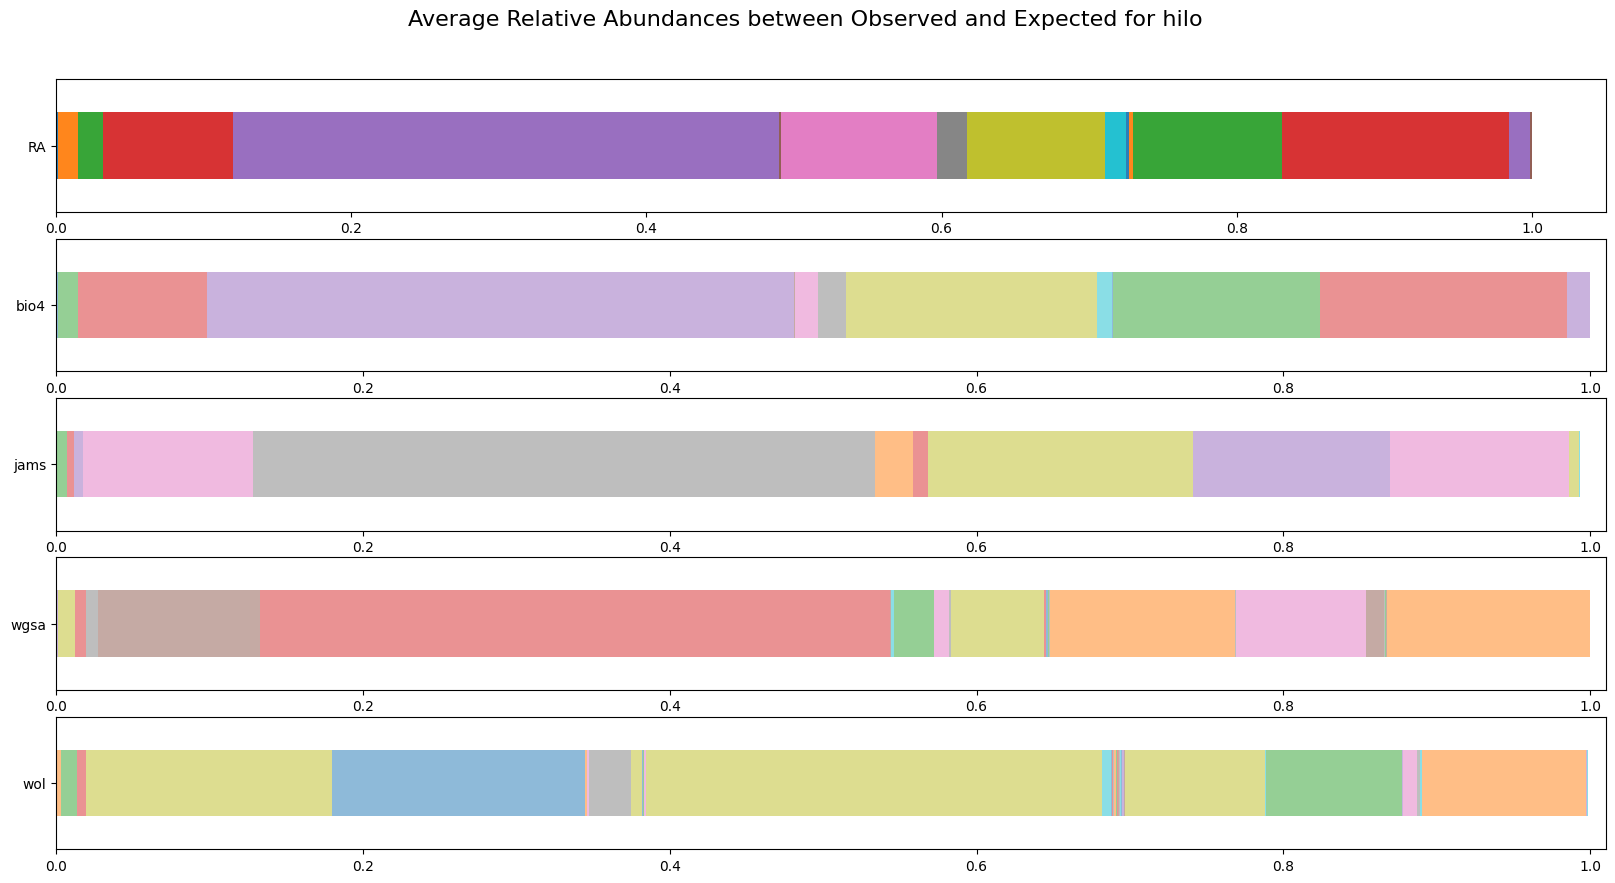

1.0


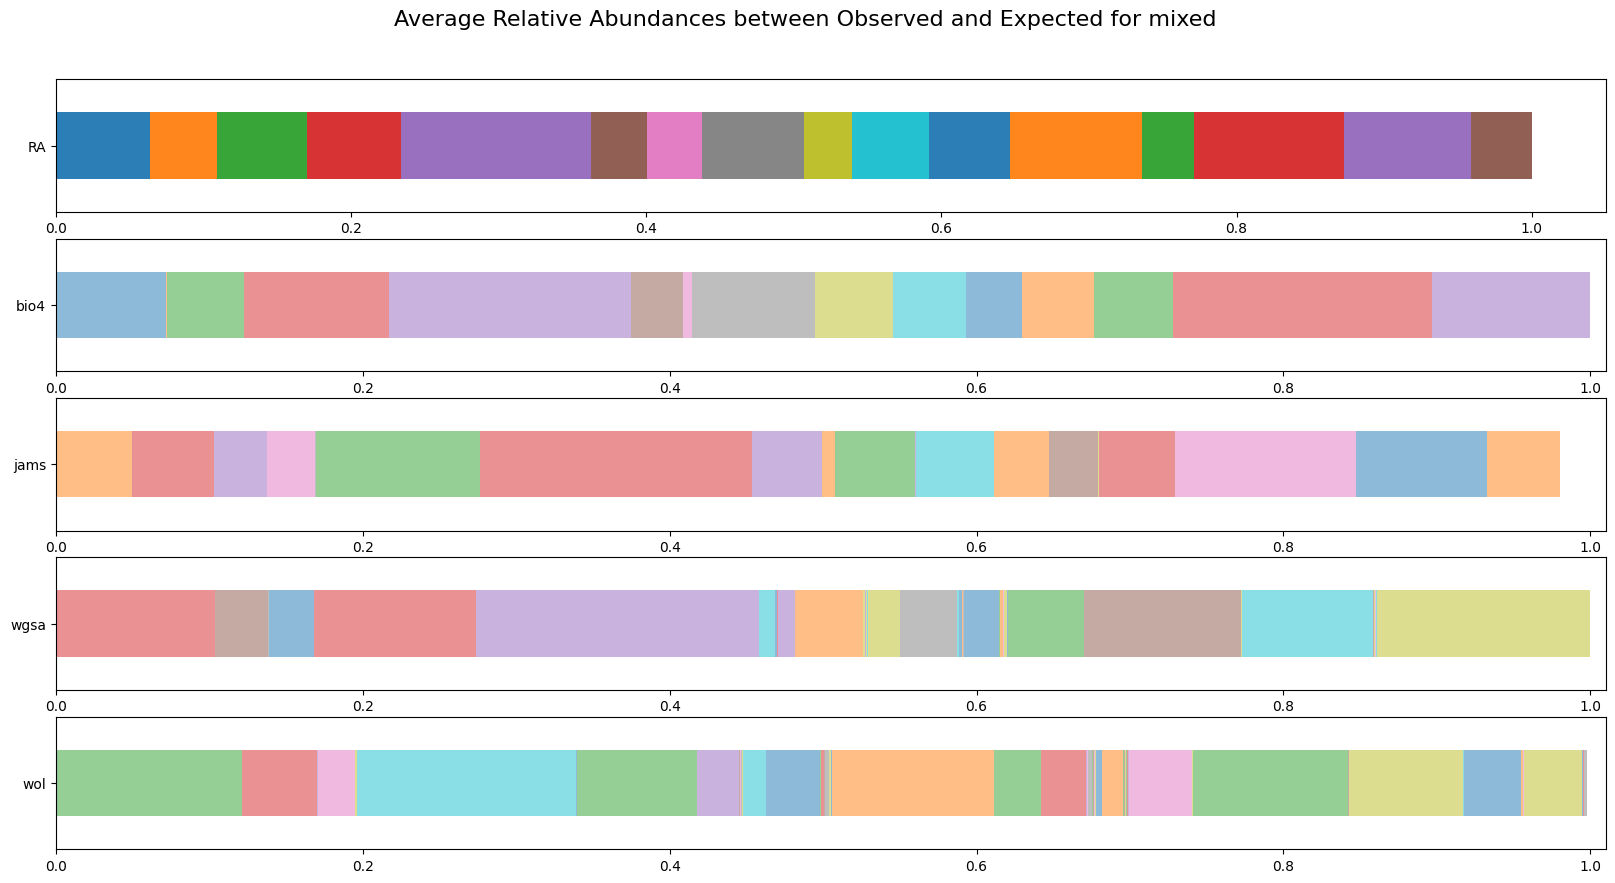

TypeError: no numeric data to plot

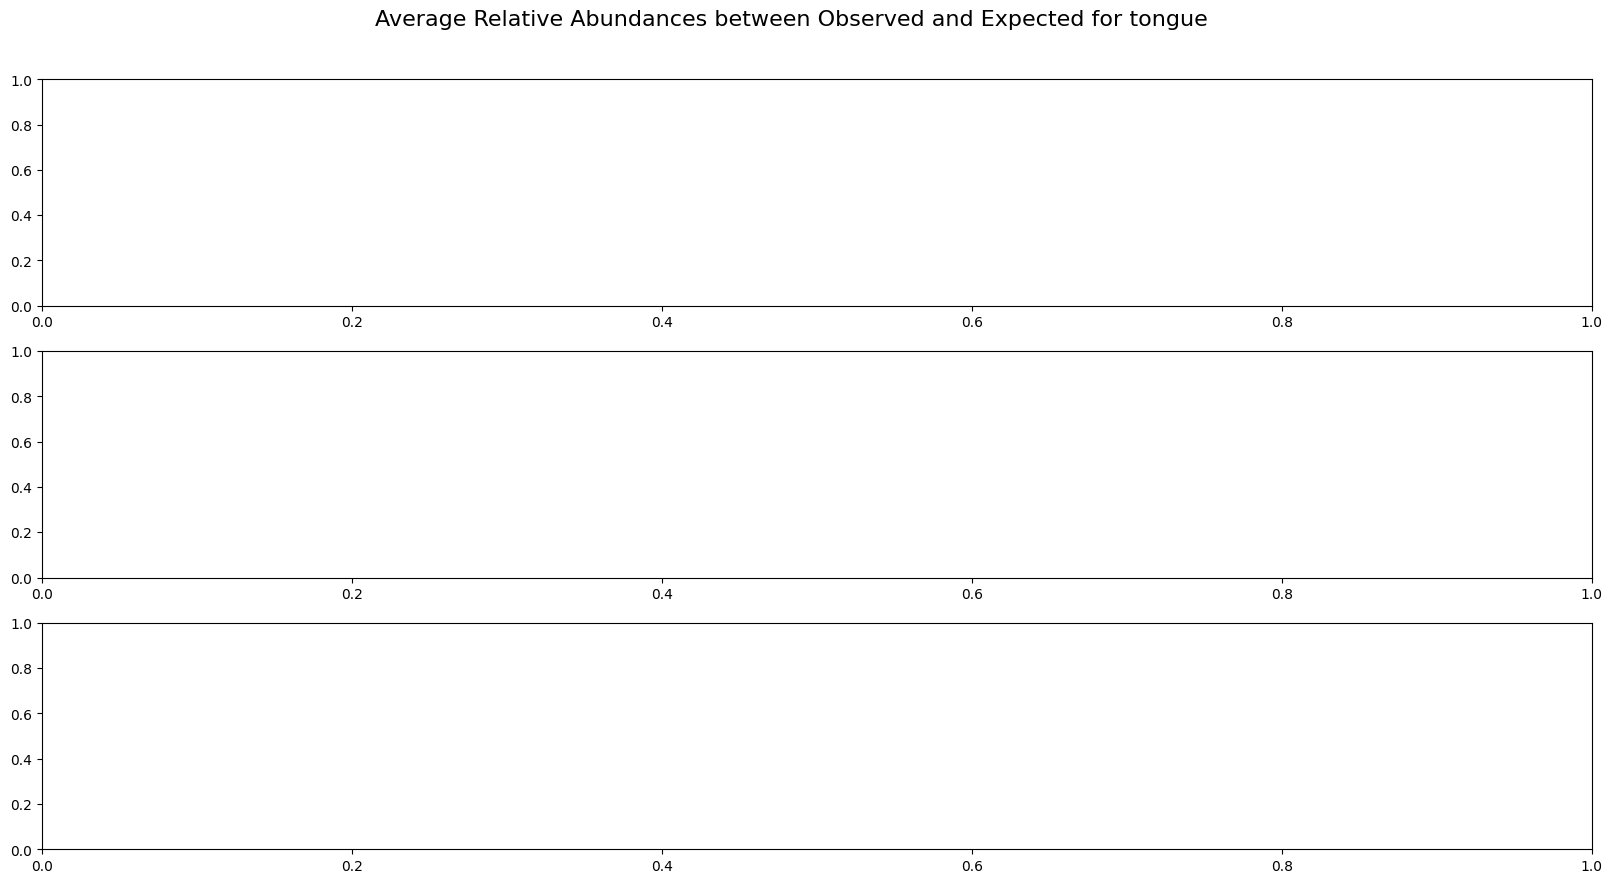

In [48]:
expected = get_all_expected("../../pipelines/", rank="Genus")
observed = get_all_relabund_files("../../pipelines/", rank="genus")

# Set xlim from 0 to 1.


for src, src_df in observed.groupby("Source"):
    if src == "bmock12" or src == "camisimGI":
        print("source: ", src)
        for smpl, smpl_df in src_df.groupby("SampleID"):
        # fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(20, 10))
        # fig.suptitle(f"Relative Abundances between Observed and Expected for {src} {smpl}", fontsize=16, y=0.95)
        # ax_c = 0
            pass
            # grouped_expected = expected.loc[(expected["Source"] == src) & (expected["SampleID"] == smpl)]
            # # grouped_expected[["RA"]].T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=False)

            # plot_df = pd.concat([smpl_df, grouped_expected], axis=0)

            # for pl, pl_df in plot_df.groupby("Pipeline"):
            #     if pl == "wgsa2" or pl == "wgsa":
            #         pl_df = fill_wgsa(pl_df, src, smpl, "Genus")

            #     # display(pl_df.head(10))
            #     T = pl_df[["RA"]].T
            #     # Change the index to the pipeline name.
            #     T.index = [pl]

            #     # display(T.head(10))

            #     ax[ax_c].set_xlim(0, 1.01)
            #     T.plot.barh(alpha=0.5, ax=ax[ax_c], legend=False, stacked=True)
            #     # ax[ax_c].set_title(f"{src} {smpl} {pl}")
            #     ax_c += 1
    else:
        # These are the replicates.
        # Get the expected that matches the source. Since these are replicates, the sampleID doesn't matter.
        groups = src_df.groupby("Pipeline")

        fig, ax = plt.subplots(nrows=len(groups)+1, ncols=1, figsize=(20, 10))
        fig.suptitle(f"Average Relative Abundances between Observed and Expected for {src}", fontsize=16, y=0.95)
        ax_c = 1

        grouped_expected = expected.loc[(expected["Source"] == src)]
        grouped_expected[["RA"]].T.plot.barh(stacked=True, ax=ax[0], alpha=0.5, legend=False)
        
        for pl, pl_df in groups:
            # We want to average all of the replicates. This is where the index values are the same.
            # Get the average of the relabund values.
            avg_df = pl_df[['RA']].groupby("genus").mean()

            if pl == "wgsa2" or pl == "wgsa":
                avg_df = fill_wgsa(avg_df, src, smpl, "genus")

            # Transpose for plotting.
            T = avg_df.T

            # Change the index to the pipeline name.
            T.index = [pl]

            ax[ax_c].set_xlim(0, 1.01)
            T.plot.barh(alpha=0.5, legend=False, stacked=True, ax=ax[ax_c])
            ax_c += 1


        plt.show()


# display(expected.head(10))
# display(observed.head(10))